In [1]:
import cv2
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import tifffile as tiff
from tifffile import imread
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import sys, cv2
from torch.cuda.amp import autocast
import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt


In [9]:
def process_scan(_scan: np.ndarray):
    scan = _scan.astype(np.float32)
    smin, smax = np.min(scan), np.max(scan)
    scan = (255 * (scan - smin) / (smax - smin)).astype(np.uint8)
    scan = 255 - scan
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
    return clahe.apply(scan)

def process_mask(slice):
    mask = slice.astype(bool)
    return mask

class SenNet(Dataset):
    def _load_slice(self, pth, process_scan):
        return torch.tensor(
            process_scan(tiff.imread(pth))
        )

    def _load_scan(self, scan_pth, preprocess_fn):
        scan = torch.stack([
            self._load_slice(os.path.join(scan_pth, f), preprocess_fn)
            for f in os.listdir(scan_pth)
            if f.endswith('.tif')
        ])
        return scan.unsqueeze(0)
        #return F.pad(
        #    scan,
        #    (self.chunk_size // 2, self.chunk_size // 2, \
        #     self.chunk_size // 2, self.chunk_size // 2),
        #).unsqueeze(0)

    def __init__(
            self,
            chunk_size: int = 256,
            guarantee_vessel: float = 0.5,
            data_dir = '/root/data',
            samples = ['/train/kidney_1_dense']
        ):
        self.chunk_size = chunk_size
        self.guarantee_vessel = guarantee_vessel
        self.folder = data_dir
        self.train_samples = samples

        self.scans = []
        self.labels = []
        self.num_chunks = 0
        for sample in self.train_samples:
            sample_pth = self.folder +  sample + '/images'
            label_pth = self.folder +  sample + '/labels'
            self.scans.append(self._load_scan(sample_pth, process_scan))
            self.labels.append(self._load_scan(label_pth, process_mask))
            self.num_chunks += self.scans[-1].numel() // (chunk_size ** 2)

    def __len__(self):
        return self.num_chunks

    def _get_along_axis(self, cube:torch.Tensor, pos:tuple[int, int, int], axs:int) -> torch.Tensor:
        if axs == 0:
            return cube[
                :,
                pos[0],
                pos[1]:pos[1]+self.chunk_size,
                pos[2]:pos[2]+self.chunk_size
            ]
        elif axs == 1:
            return cube[
                :,
                pos[0]:pos[0]+self.chunk_size,
                pos[1],
                pos[2]:pos[2]+self.chunk_size
            ]
        elif axs == 2:
            return cube[
                :,
                pos[0]:pos[0]+self.chunk_size,
                pos[1]:pos[1]+self.chunk_size,
                pos[2]
            ]

    def __getitem__(self, idx):
        scan_idx = np.random.randint(len(self.scans))
        rot_idx = 0
        # rot_idx = np.random.randint(3)
        found_vessel = False if np.random.rand() > self.guarantee_vessel else True
        x, y, z = None, None, None
        while not found_vessel or x is None:
            x = np.random.randint(0, self.scans[scan_idx].shape[1] - self.chunk_size)
            y = np.random.randint(0, self.scans[scan_idx].shape[2] - self.chunk_size)
            z = np.random.randint(0, self.scans[scan_idx].shape[3] - self.chunk_size)
            patch_label = self._get_along_axis(self.labels[scan_idx], (x,y,z), rot_idx)

            found_vessel = patch_label.sum() > 0

        return self._get_along_axis(self.scans[scan_idx], (x,y,z), rot_idx),\
            patch_label


train = SenNet(chunk_size=900, samples=["/train/kidney_1_dense"], guarantee_vessel=1)
test = SenNet(chunk_size=900, samples=["/train/kidney_2"], guarantee_vessel=1)


train_data = DataLoader(train, batch_size=4, shuffle=True)
valid_data = DataLoader(test, batch_size=4, shuffle=True)
#valid_data = DataLoader(test, batch_size=128 // 4, shuffle=True)
#train_data = DataLoader(train, batch_size=32, shuffle=True)
#valid_data = DataLoader(test, batch_size=32 // 4, shuffle=True)
# Create an instance of the class with your arguments
#dataset = SenNet(chunk_size=256, guarantee_vessel=0.5)


: 

In [4]:
import torch
# check if GPU is available
if torch.cuda.is_available ():
  # select the first GPU device
  device = torch.device ("cuda:0")
else:
  # use CPU if no GPU is available
  device = torch.device ("cpu")


In [5]:
# dice coefficient
def dice_coef(y_pred:torch.Tensor,y_true:torch.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred=y_pred.sigmoid()
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice # Standard dice
        # gamma = 1.5
        # return (1 - dice)**gamma # focuses on difficult examples

In [6]:
# Config File
p_augm = 0.5

class CFG:
    target_size = 1
    model_name = 'Unet'
    backbone = 'resnext50_32x4d'
    in_chans = 1
    image_size = 512
    input_size = 512
    train_batch_size = 16
    valid_batch_size = 16
    epochs = 25
    lr = 6e-5
    chopping_percentile = 1e-3

    valid_id = 1
    rotate_p = 0.02

    p_augm = 0.5

    train_aug_list = [
        A.Rotate(limit=270, p= rotate_p),
        A.RandomScale(scale_limit=(0.8, 1.25), interpolation=cv2.INTER_CUBIC, p=p_augm),
        A.RandomCrop(input_size, input_size, p=1),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        ToTensorV2(transpose_mask=True),
    ]

    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug_list = A.Compose(valid_aug_list)


In [7]:
# Model
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone,
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.model(image)
        return output[:,0]


def build_model(weight="imagenet"):
    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()


In [8]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model=build_model()
model=DataParallel(model)
loss_fc=DiceLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=CFG.lr)
scaler=torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, steps_per_epoch=len(train_data), epochs=CFG.epochs+1, pct_start=0.1)

for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_data)))
    losss = 0
    scores = 0
    for i,(x,y) in enumerate(train_data):
        x=x.cuda().to(torch.float32)
        y=y.cuda().to(torch.float32)
        #x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        #x=add_noise(x,mad_randn_rate=0.5,x_already_normed=True)

        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score.item())/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()

    model.eval()
    time=tqdm(range(len(valid_data)))
    val_losss = 0
    val_scores = 0
    for i,(x,y) in enumerate(valid_data):
        x=x.cuda().to(torch.float32)
        y=y.cuda().to(torch.float32)
        #x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with torch.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
torch.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_rot002.pt")

time.close()


model_name Unet
backbone resnext50_32x4d


  0%|          | 0/677 [00:00<?, ?it/s]

ValueError: high <= 0

In [ ]:
# Threshold Range Testing
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=CFG.lr)
scaler=torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, steps_per_epoch=len(train_data), epochs=CFG.epochs+1, pct_start=0.1)

for epoch in range(CFG.epochs):
    # Existing code...
    model.train()
    time=tqdm(range(len(train_data)))
    losss = 0
    scores = 0
    for i,(x,y) in enumerate(train_data):
        x=x.cuda().to(torch.float32)
        y=y.cuda().to(torch.float32)
        #x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        #x=add_noise(x,mad_randn_rate=0.5,x_already_normed=True)

        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score.item())/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()

    model.eval()
    time = tqdm(range(len(valid_data)))
    val_losss = 0
    val_scores = 0
    
    # Calculate dice coefficients for different thresholds
    threshold_values = [0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
    dice_scores = {thr: 0 for thr in threshold_values}  # Store scores for each threshold
    
    for i, (x, y) in enumerate(valid_data):
        x = x.cuda().to(torch.float32)
        y = y.cuda().to(torch.float32)
        
        with autocast():
            with torch.no_grad():
                pred = model(x)
                loss = loss_fc(pred, y)
        
        # Calculate dice coefficients for different thresholds
        for thr in threshold_values:
            score = dice_coef(pred.detach(), y, thr=thr)
            dice_scores[thr] = (dice_scores[thr] * i + score.item()) / (i + 1)
        
        # Calculate average loss for validation
        val_losss = (val_losss * i + loss.item()) / (i + 1)
        time.set_description(f"val-->loss:{val_losss:.4f}")
        time.update()

    # Print dice coefficients for different thresholds
    print(f"Epoch {epoch} Validation Dice Scores for Different Thresholds:")
    for thr, score in dice_scores.items():
        print(f"Threshold: {thr}, Dice Score: {score:.4f}")
    
    time.close()

# Save the model state after training
torch.save(model.module.state_dict(), f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_rot002.pt")

In [1]:
model.eval()

NameError: name 'model' is not defined

In [102]:
x_batch, y_batch = next(iter(valid_data))

with torch.no_grad():
    pred_batch = model(x_batch.cuda().to(torch.float32))

x_1 = x_batch[0].cpu().numpy().transpose(1,2,0)
y_1 = y_batch[0].cpu().numpy().squeeze(0)
pred_1 = pred_batch[0].cpu().numpy()

x_1_tc = torch.from_numpy(x_1)
y_1_tc = torch.from_numpy(y_1)
pred_1_tc = torch.from_numpy(pred_1)
pred_1_tc = pred_1_tc.sigmoid()
pred_1_tc_fix = (pred_1_tc > 0.5)
x_t_tc_fix = x_1_tc.to(torch.float32)
y_1_tc = y_1_tc.to(torch.float32)
pred_1_tc_fix = pred_1_tc_fix.to(torch.float32)
inter = (y_1_tc*pred_1_tc_fix).sum(dim=(-1,-2))
den = y_1_tc.sum(dim=(-1,-2)) + pred_1_tc_fix.sum(dim=(-1,-2))
dice = ((2*inter+0.001)/(den+0.001)).mean()

In [103]:
dice

tensor(0.9306)

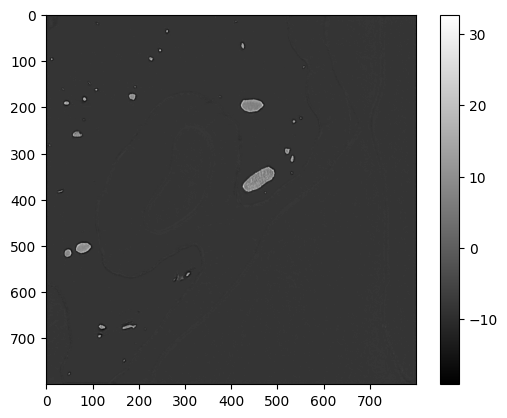

In [104]:
plt.imshow(pred_1, cmap='gray')
plt.colorbar()

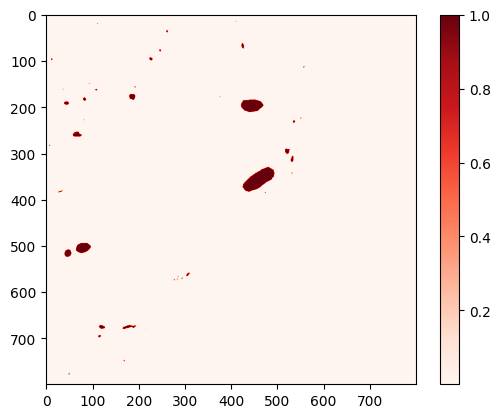

In [105]:
plt.imshow(pred_1_tc, cmap='Reds')
plt.colorbar()

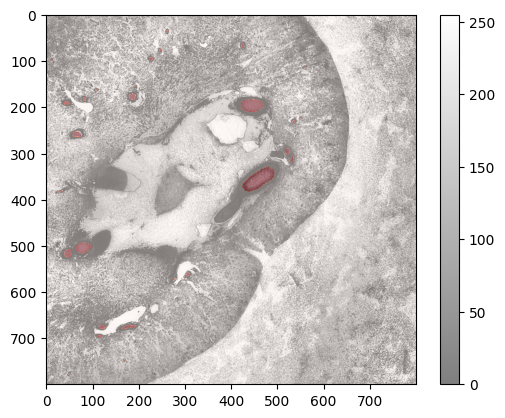

In [106]:
plt.imshow(pred_1_tc_fix, cmap='Reds')
#plt.imshow(y_1, cmap='Blues', alpha=0.5)
plt.imshow(x_t_tc_fix, cmap='gray', alpha=0.5)
plt.colorbar()

In [4]:
num_samples_to_visualize = 5  # Adjust this as needed
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(x_batch[i].cpu().numpy().transpose(1, 2, 0))  # Assuming images are in CHW format

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    # Reshape ground truth mask if needed (assuming single-channel mask)
    gt_mask = y_batch[i].cpu().numpy()
    if len(gt_mask.shape) == 3:
        gt_mask = gt_mask.squeeze(0)  # Remove the channel dimension if present
    plt.imshow(gt_mask, cmap='gray')  # Display ground truth mask

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_batch[i].cpu().numpy(), cmap='gray')  # Assuming binary masks (adjust as needed)

    plt.show()